# Finetuning moondream

This notebook demonstrates how to fine-tune [moondream](https://github.com/vikhyat/moondream) (the world's best small vision language model) to improve performance on a downstream task.
For this example, we'll fine-tune on a [Captcha image dataset](https://huggingface.co/datasets/project-sloth/captcha-images).

The first step is to construct a dataset split into `train`, `validation`, and `test` sets. This is
not strictly necessary and can be skipped if you're fine-tuning on a very small amount of data. We
will train the model on the `train` set, use the `validation` set to tune hyperparameters and prevent
overfitting, and finally evaluate the model on the `test` set.

In [1]:
%pip install torch transformers==4.41.2 timm einops datasets bitsandbytes accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 59.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 68.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.0
    Uninstalling tokenizers-0.20.0:
      Successfully uninstalled tokenizers-0.20.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.45.1
    Uninstalling transformers-4.45.1:
      Successfully uninstalled transformers-4.45.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
import torch
import requests
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from tqdm import tqdm
from einops import rearrange
from bitsandbytes.optim import Adam8bit
from transformers import AutoTokenizer, AutoModelForCausalLM
from torch.utils.data import Dataset, DataLoader, random_split

In [5]:
df = pd.read_parquet('../input/category_attributes.parquet')
df

attr_mens_tshirt = list(df["Attribute_list"][0])
attr_sarees = list(df["Attribute_list"][1])
attr_kurtis = list(df["Attribute_list"][2])
attr_womens_tshirts = list(df["Attribute_list"][3])
attr_womens_tops_tunics = list(df["Attribute_list"][4])
attr_womens_tops_tunics[4] = "occasion"

In [ ]:
attr_womens_tshirts

['blouse_pattern',
 'border',
 'border_width',
 'color',
 'occasion',
 'ornamentation',
 'pallu_details',
 'pattern',
 'print_or_pattern_type',
 'transparency']

In [ ]:
def create_input_prompt(row):
    attributes = ', '.join([
        f"{col}: {row[col]}" for col in attr_womens_tops_tunics
        if pd.notna(row[col]) and row[col] != 'default'
    ])
    prompt = f"Describe a with the following attributes: {attributes}."
    return prompt

In [ ]:
def create_synthetic_description(row):
    # Extract attributes, handling missing values
    attributes = []
    for i in attr_sarees:
        if i == 'pattern'and  pd.notna(row[i]) and row[i] != 'default':
            attributes.append(f"{row[i]} pattern")
        elif i == 'print_or_pattern_type' and pd.notna(row[i]) and row[i] != 'default':
            attributes.append(f"{row[i]} type")
        elif i == 'fit_shape' and pd.notna(row[i]) and row[i] != 'default':
                attributes.append(f"{row[i]} shape")
        elif i == 'length' and pd.notna(row[i]) and row[i] != 'default':
                    attributes.append(f"{row[i]} length")
        elif pd.notna(row[i]) and row[i] != 'default':
            attributes.append(f"{row[i]}")

    # Construct the description
    description = "A women's tshirt featuring " + ', '.join(attributes) + '.'
    return description

In [ ]:
from torch.utils.data import Dataset
from datasets import load_dataset

class DimensionsDataset(Dataset):
    def __init__(self, csv_file_path, transform=None):
        self.data = pd.read_csv(csv_file_path)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    @staticmethod
    def transform1(image):
        image = image.convert("L")
        image = image.point(lambda p: p * 1.2)
        image = image.point(lambda p: p > 205 and 255)
        image = image.filter(ImageFilter.MinFilter(3))
        return image

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join('../input/train_images', f"{int(self.data.iloc[idx, 0]):06d}.jpg")
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "qa": [
                {
                    "question": "Describe this women's tshirt",
                    "answer": create_synthetic_description(row),
                }
            ]
        }

dset = DimensionsDataset(
    "../input/Women_Tshirts.csv",
    transform=None,
)
trns = int(0.8 * len(dset))
trnd, vald = random_split(dset, [trns, len(dset) - trns])

datasets = {
    "train": trnd,
    "val": vald,
    "test": vald,
}

Now let's take a look at a sample image from the training set and compare the ground-truth answers
with moondream predictions.

In [12]:
# Initialize moondream. Change DEVICE to 'mps' if you're on an M1 Mac, or 'cpu' if you don't have a
# GPU. Note that fine-tuning on CPU will be very slow.

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

DEVICE = "cuda"
DTYPE = torch.float32 if DEVICE == "cpu" else torch.float16 # CPU doesn't support float16
MD_REVISION = "2024-03-13"

tokenizer = AutoTokenizer.from_pretrained("vikhyatk/moondream2", revision=MD_REVISION)
moondream = AutoModelForCausalLM.from_pretrained(
    "vikhyatk/moondream2", revision=MD_REVISION, trust_remote_code=True,
    torch_dtype=DTYPE, device_map={"": DEVICE}
)

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/318 [00:00<?, ?B/s]

configuration_moondream.py:   0%|          | 0.00/3.39k [00:00<?, ?B/s]

moondream.py:   0%|          | 0.00/5.41k [00:00<?, ?B/s]

modeling_phi.py:   0%|          | 0.00/49.4k [00:00<?, ?B/s]

vision_encoder.py:   0%|          | 0.00/3.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

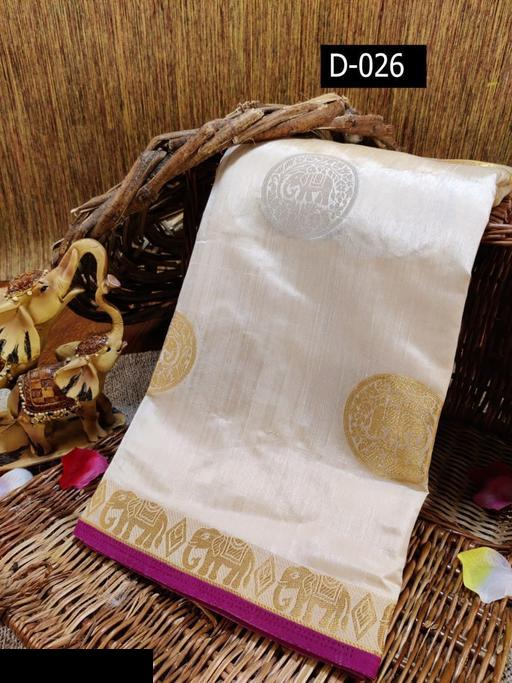

Question: Describe this saree
Ground Truth: A saree featuring same as saree, zari, small border, cream, party, jacquard, woven design, zari woven pattern, elephant type, no.
Moondream: The image features a white saree with gold and pink accents, placed on a table. The saree has a unique design, featuring elephants as a prominent element. The elephants are positioned in various sizes and are spread across the entire length of the saree. The white color of the saree contrasts beautifully with the gold and pink accents, creating an elegant and eye-catching appearance.


In [20]:
from IPython.display import display
import os
sample = datasets['train'][0]
display(sample['image'])

for qa in sample['qa']:
    print('Question:', qa['question'])
    print('Ground Truth:', qa['answer'])
    print('Moondream:', moondream.answer_question(
        moondream.encode_image(sample['image']),
        qa['question'],
        tokenizer=tokenizer,
    ))

Let's start setting up hyperparameters for finetuning.

In [21]:
# Number of times to repeat the training dataset. Increasing this may cause the model to overfit or
# lose generalization due to catastrophic forgetting. Decreasing it may cause the model to underfit.
EPOCHS = 1

# Number of samples to process in each batch. Set this to the highest value that doesn't cause an
# out-of-memory error. Decrease it if you're running out of memory. Batch size 8 currently uses around
# 15 GB of GPU memory during fine-tuning.
BATCH_SIZE = 8

# Number of batches to process before updating the model. You can use this to simulate a higher batch
# size than your GPU can handle. Set this to 1 to disable gradient accumulation.
GRAD_ACCUM_STEPS = 1

# Learning rate for the Adam optimizer. Needs to be tuned on a case-by-case basis. As a general rule
# of thumb, increase it by 1.4 times each time you double the effective batch size.
#
# Source: https://www.cs.princeton.edu/~smalladi/blog/2024/01/22/SDEs-ScalingRules/
#
# Note that we linearly warm the learning rate up from 0.1 * LR to LR over the first 10% of the
# training run, and then decay it back to 0.1 * LR over the last 90% of the training run using a
# cosine schedule.
LR = 3e-5

# Whether to use Weights and Biases for logging training metrics.
USE_WANDB = False


This next block will start the training process.

In [ ]:
from torch.utils.data import DataLoader
from bitsandbytes.optim import Adam8bit
import math
from einops import rearrange
from tqdm import tqdm

# The current version of moondream uses "<END>" to denote the end of a response. In the future this
# will be replaced with a special token.
ANSWER_EOS = "<END>"

# Number of tokens used to represent each image.
IMG_TOKENS = 729

def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    images = torch.stack(moondream.vision_encoder.preprocess(images))
    images = rearrange(images,
                       "b c (h p1) (w p2) -> b (h w) (c p1 p2)",
                       p1=14, p2=14)

    labels_acc = []
    tokens_acc = []

    for sample in batch:
        toks = [tokenizer.bos_token_id]
        labs = [-100] * (IMG_TOKENS + 1)

        for qa in sample['qa']:
            q_t = tokenizer(
                f"\n\nQuestion: {qa['question']}\n\nAnswer:",
                add_special_tokens=False
            ).input_ids
            toks.extend(q_t)
            labs.extend([-100] * len(q_t))

            a_t = tokenizer(
                f" {qa['answer']}{ANSWER_EOS}",
                add_special_tokens=False
            ).input_ids
            toks.extend(a_t)
            labs.extend(a_t)

        tokens_acc.append(toks)
        labels_acc.append(labs)

    max_len = -1
    for labels in labels_acc:
        max_len = max(max_len, len(labels))

    attn_mask_acc = []

    for i in range(len(batch)):
        len_i = len(labels_acc[i])
        pad_i = max_len - len_i

        labels_acc[i].extend([-100] * pad_i)
        tokens_acc[i].extend([tokenizer.eos_token_id] * pad_i)
        attn_mask_acc.append([1] * len_i + [0] * pad_i)

    return (
        images.to(dtype=DTYPE),
        torch.stack([torch.tensor(t, dtype=torch.long) for t in tokens_acc]),
        torch.stack([torch.tensor(l, dtype=torch.long) for l in labels_acc]),
        torch.stack([torch.tensor(a, dtype=torch.bool) for a in attn_mask_acc]),
    )

def compute_loss(batch):
    images, tokens, labels, attn_mask = batch

    images = images.to(DEVICE)
    tokens = tokens.to(DEVICE)
    labels = labels.to(DEVICE)
    attn_mask = attn_mask.to(DEVICE)

    with torch.no_grad():
        img_embs = moondream.vision_encoder.encoder(images)
        img_embs = moondream.vision_encoder.projection(img_embs)

    tok_embs = moondream.text_model.get_input_embeddings()(tokens)
    inputs_embeds = torch.cat((tok_embs[:, 0:1, :], img_embs, tok_embs[:, 1:, :]), dim=1)

    outputs = moondream.text_model(
        inputs_embeds=inputs_embeds,
        labels=labels,
        attention_mask=attn_mask,
    )

    return outputs.loss

def lr_schedule(step, max_steps):
    x = step / max_steps
    if x < 0.1:
        return 0.1 * LR + 0.9 * LR * x / 0.1
    else:
        return 0.1 * LR + 0.9 * LR * (1 + math.cos(math.pi * (x - 0.1))) / 2

dataloaders = {
    "train": DataLoader(
        datasets["train"],
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
    ),
    "val": DataLoader(
        datasets["val"],
        batch_size=BATCH_SIZE,
        collate_fn=collate_fn,
    ),
}

moondream.text_model.train()
moondream.text_model.transformer.gradient_checkpointing_enable()

total_steps = EPOCHS * len(dataloaders["train"]) // GRAD_ACCUM_STEPS
optimizer = Adam8bit(
    [
        {"params": moondream.text_model.parameters()},
    ],
    lr=LR * 0.1,
    betas=(0.9, 0.95),
    eps=1e-6
)

if USE_WANDB:
    import wandb
    wandb.init(
        project="moondream-ft",
        config={
            "EPOCHS": EPOCHS,
            "BATCH_SIZE": BATCH_SIZE,
            "GRAD_ACCUM_STEPS": GRAD_ACCUM_STEPS,
            "LR": LR,
        }
    )

i = 0
for epoch in range(EPOCHS):
    for batch in tqdm(dataloaders["train"], desc=f"Epoch {epoch + 1}/{EPOCHS}"):
        i += 1

        loss = compute_loss(batch)
        loss.backward()

        if i % GRAD_ACCUM_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

            lr = lr_schedule(i / GRAD_ACCUM_STEPS, total_steps)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

        if i % 100 == 0 and USE_WANDB:
            # Calculate validation loss
            val_loss = 0
            for val_batch in tqdm(dataloaders["val"], desc="Validation"):
                with torch.no_grad():
                    val_loss += compute_loss(val_batch).item()
            val_loss /= len(dataloaders["val"])

        if USE_WANDB:
            wandb.log({
                "loss/train": loss.item(),
                "lr": optimizer.param_groups[0]['lr']
            } | ({"loss/val": val_loss} if i % 100 == 0 else {}))

if USE_WANDB:
    wandb.finish()

Epoch 1/1:   0%|          | 0/1835 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignore[attr-defined]
Epoch 1/1:   3%|▎         | 57/1835 [06:56<3:34:37,  7.24s/it]

Now that training has completed, let's inspect a few samples and calculate accuracy.

In [ ]:
moondream.eval()

correct = 0

for i, sample in enumerate(datasets['test']):
    md_answer = moondream.answer_question(
        moondream.encode_image(sample['image']),
        sample['qa'][0]['question'],
        tokenizer=tokenizer,
    )

    if md_answer == sample['qa'][0]['answer']:
        correct += 1

    if i < 3:
        display(sample['image'])
        print('Question:', sample['qa'][0]['question'])
        print('Ground Truth:', sample['qa'][0]['answer'])
        print('Moondream:', md_answer)

print(f"\n\nAccuracy: {correct / len(datasets['test']) * 100:.2f}%")

In [ ]:
df_test_mens_tshirts = pd.read_csv("../input/test_folder/test_folder/test_Women_Tshirts.csv")

In [ ]:
import os
import csv
from PIL import Image
import pandas as pd
import numpy as np
csv_file_path = "/kaggle/working/output_women_tshirts.csv"
category = "Women Tshirts"
length = 5 

if not os.path.exists(csv_file_path):
    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(["id", "Category", "len", "response"])

for row in df_test_mens_tshirts.itertuples(index=False):
    image_id = str(row.id).zfill(6)
    image_path = f"../input/test_images/{image_id}.jpg"

    if os.path.exists(image_path):
        raw_image = Image.open(image_path).convert('RGB')
        print(raw_image)
        predicted_attributes = moondream.answer_question(
                moondream.encode_image(raw_image),
                "Describe this women's tshirt",
                tokenizer=tokenizer,
            )
        print(predicted_attributes)
        
        

        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
            writer.writerow([image_id, category, length, predicted_attributes])
    else:
        print(f"Image {image_id}.jpg not found.")